# 1. 训练模型 （数据清理、特征化）
# 2. 预测

In [1]:
import jieba

In [3]:
cuts= jieba.lcut('标准间太差 房间还不如3星的 而且设施非常陈旧.建议酒店把老的标准间从新改善.')

In [4]:
cuts

['标准间',
 '太',
 '差',
 ' ',
 '房间',
 '还',
 '不如',
 '3',
 '星',
 '的',
 ' ',
 '而且',
 '设施',
 '非常',
 '陈旧',
 '.',
 '建议',
 '酒店',
 '把',
 '老',
 '的',
 '标准间',
 '从',
 '新',
 '改善',
 '.']

In [5]:
len(cuts)

26

In [ ]:
'设施' '非常', '陈旧'

In [9]:
import pandas as pd
import numpy as np
import jieba
import jieba.posseg as pseg
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [10]:
stop_list=list(set(pd.read_table('chinese-stopword.txt',sep='\t',names=['stop'])['stop']))

In [11]:
def is_chinese(uchar):
#   判断一个unicode是否是汉字
    if uchar >= u'\u4e00' and uchar <= u'\u9fa5':
        return True
    else:
        return False

In [12]:
def get_data_df():
#   获取正负例dataframe 和 停用词list
    neg_df=pd.read_table('neg.txt',sep='\t',names=['label','chat'])
    pos_df=pd.read_table('pos.txt',sep='\t',names=['label','chat'])
    stop_list=list(set(pd.read_table('chinese-stopword.txt',sep='\t',names=['stop'])['stop']))
    return neg_df,pos_df,stop_list

In [13]:
def jieba_getdata(str_str,stopwords=stop_list):
#   结巴切词
    cut_list=jieba.lcut(str_str)
    cut_list=[iword for iword in cut_list if iword not in stopwords]
    cut_list=[iword for iword in cut_list if is_chinese(iword) is True]
    cut_str=' '.join(cut_list)
    return cut_str

In [14]:
def jieba_getdata_adjective(str_str,stopwords=stop_list):
#   利用结巴词性标注的选取形容词
    words=pseg.cut(str_str)
    cut_list=[i.word for i in words if i.flag=='a']
    cut_list=[iword for iword in cut_list if iword not in stopwords]
    cut_list=[iword for iword in cut_list if is_chinese(iword) is True]
    cut_str=' '.join(cut_list)
    return cut_str

In [15]:
def get_cut_word(method_select):
#   选取两种方式进行切词 : jieba_getdata_adjective or jieba_getdata
    neg_df,pos_df,stop_list = get_data_df()
    neg_df['cut']=neg_df['chat'].map(str).apply(method_select)
    del neg_df['chat']
    pos_df['cut']=pos_df['chat'].map(str).apply(method_select)
    del pos_df['chat']
    return neg_df,pos_df

In [16]:
def get_xdata_label(method_select):
#   词频特征的向量化
    neg_df,pos_df = get_cut_word(method_select)
    xdata=[]
    ylabel=[]
    neg_pos = pd.concat([neg_df,pos_df])
    for i in range(len(neg_pos)):
        ixdata = neg_pos.iloc[i,1]
        ilabel = neg_pos.iloc[i,0]
        if ixdata!='':
            xdata.append(ixdata)
            ylabel.append(ilabel)
    return xdata,ylabel

In [21]:
neg_df,pos_df,stop_list = get_data_df()

In [22]:
neg_df.head()

,label,chat
0,-1,标准间太差房间还不如3星的而且设施非常陈旧.建议酒店把老的标准间从新改善.
1,-1,服务态度极其差，前台接待好象没有受过培训，连基本的礼貌都不懂，竟然同时接待几个客人；大堂副理...
2,-1,地理位置还不错，到哪里都比较方便，但是服务不象是豪生集团管理的，比较差。下午睡了一觉并洗了一...
3,-1,1。我住的是靠马路的标准间。房间内设施简陋，并且的房间玻璃窗户外还有一层幕墙玻璃，而且不能打...
4,-1,我这次是第5次住在长春的雁鸣湖大酒店。昨晚夜里停电。深夜我睡着了。我的钱包被内贼进入我的房间...


In [23]:
xdata,ylabel=get_xdata_label(jieba_getdata)

In [24]:
xdata[0:10]

['标准间 太 差 房间 星 设施 陈旧 建议 酒店 标准间 新 改善',
 '服务态度 差 前台 接待 好象 受过 培训 礼貌 懂 接待 几个 客人 大堂 副理 差 客人 辩解 没完 总经理 电话 投诉 不敢 作 亏心事 情 跟本 不用',
 '地理位置 不错 比较 方便 服务 象是 豪生 集团 管理 比较 差 下午 睡 一觉 洗 一个 澡 本来 想 酒店 打扫 一下 打开 请 打扫 服务 灯 晚上 回 酒店 发现 打扫 服务 灯 关掉 房间 打扫',
 '住 马路 标准间 房间内 设施 简陋 房间 玻璃窗 户外 一层 幕墙 玻璃 打开 导致 房间 自然通风 采光 不好 吃 三顿 早餐 品种 少得 可怜 二楼 餐厅 租出去 价格 特贵 原来 订餐 时告 房客 九折 房间 服务指南 里 明明白白 写 结帐 时 告 海鲜 酒水 打折 发票 找 经理 好不容易 第二天 拿到 发票 综合 四星级 差距 太大',
 '次住 长春 雁鸣 湖 大酒店 昨晚 夜里 停电 深夜 睡着 钱包 贼 进入 房间 偷 元 张 信用卡 证件 外币 数码相机 房间 保险箱 里 原封不动 好几个 小时 长途电话 处理 信用卡 冻结 报案 星 酒店 保安 摄像 探头 坏 修理 保安 查房 卡 入门 时间 其他人 深夜 进入 房间 贼 高明 方式 进入 羽绒服 贼 放在 地上 醒来时 多想 中午 时 发觉 钱包 少 现金 信用卡 这家 酒店 态度 很差 同情心 之前 授权 元 国际 电话 银行 说 两天 前 我入 酒店 元 授权 酒店 财务 不领情 说 中国银行 授权 国际 电话 银行 说 这家 星级 酒店 负责 认为 发生 报案 下次 再也 不住 星 不到 服务态度 可耻 事件 说 想定 酒店 住客 酒店 停电 摄像头 坏 太 知道 这种 贼 行为 强力 打击 说 千元 丢 小事 酒店 处理 态度 反感 强力 告诉 提醒 其他人 酒店',
 '前台 花 分钟 分钟 这是 服务态度 做到 位 信用卡 刷 几次 愿意 手工 打电话 授权 典型 国营企业 极差 服务态度',
 '房 梯部 不吸 吸者 有服 抽 成 二手 受害者 中 人口 中 民 不到 看到 民',
 '酒店 服务态度 极差 设施 很差 建议',
 '预定 标间 说 会议 房间 我订 房间 太 讲 信誉 下次 再也不会 住',
 '房间 

In [25]:
ylabel[0:10]

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [26]:
# 统计词频作为特征
count_vec = CountVectorizer() #实例化
X_count_train = count_vec.fit_transform(xdata)  
# X_count_data = count_vec.transform(xdata)
X_train_count, X_test_count, y_train_count, y_test_count = \
    train_test_split(X_count_train, ylabel, test_size=0.25)  

In [24]:
X_train_count

<7422x25803 sparse matrix of type '<class 'numpy.int64'>'
	with 212736 stored elements in Compressed Sparse Row format>

In [27]:
# tf-idf作为特征
tfidf_vec = TfidfVectorizer()
X_tfidf_train = tfidf_vec.fit_transform(xdata)  
# X_tfidf_data = tfidf_vec.transform(xdata)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = \
    train_test_split(X_tfidf_train, ylabel, test_size=0.25)  


In [28]:
# 引入模型
mnb_count = MultinomialNB()
bnb_count = BernoulliNB()
mnb_tfidf = MultinomialNB()
bnb_tfidf = BernoulliNB()

In [29]:
# 准备模型评估特征
mnb_count.fit(X_train_count,y_train_count)
bnb_count.fit(X_train_count,y_train_count)
mnb_tfidf.fit(X_train_tfidf,y_train_tfidf)
bnb_tfidf.fit(X_train_tfidf,y_train_tfidf)

y_pred_count_mnb = mnb_count.predict_proba(X_test_count)[:,1]
fpr_count_mnb, tpr_count_mnb, _ = roc_curve(y_test_count, y_pred_count_mnb) #roc曲线

y_pred_count_bnb = bnb_count.predict_proba(X_test_count)[:,1]
fpr_count_bnb, tpr_count_bnb, _ = roc_curve(y_test_count, y_pred_count_bnb) #roc曲线

y_pred_tfidf_mnb = mnb_tfidf.predict_proba(X_test_tfidf)[:,1]
fpr_tfidf_mnb, tpr_tfidf_mnb, _ = roc_curve(y_test_tfidf, y_pred_tfidf_mnb) #roc曲线

y_pred_tfidf_bnb = bnb_tfidf.predict_proba(X_test_tfidf)[:,1]
fpr_tfidf_bnb, tpr_tfidf_bnb, _ = roc_curve(y_test_tfidf, y_pred_tfidf_bnb) #roc曲线


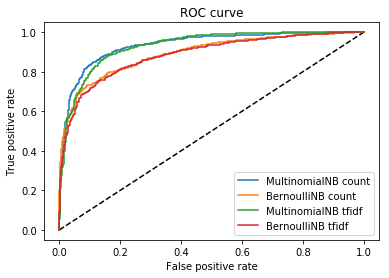

AUC MultinomialNB COUNT Score (Train): 0.936143
AUC BernoulliNB COUNT Score (Train): 0.892806
AUC MultinomialNB TFIDF Score (Train): 0.930744
AUC BernoulliNB TFIDF Score (Train): 0.885390


In [30]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_count_mnb, tpr_count_mnb, label='MultinomialNB count')
plt.plot(fpr_count_bnb, tpr_count_bnb, label='BernoulliNB count')
plt.plot(fpr_tfidf_mnb, tpr_tfidf_mnb, label='MultinomialNB tfidf')
plt.plot(fpr_tfidf_bnb, tpr_tfidf_bnb, label='BernoulliNB tfidf')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC MultinomialNB COUNT Score (Train): %f" % roc_auc_score(y_test_count, y_pred_count_mnb))
print ("AUC BernoulliNB COUNT Score (Train): %f" % roc_auc_score(y_test_count, y_pred_count_bnb))
print("AUC MultinomialNB TFIDF Score (Train): %f" % roc_auc_score(y_test_tfidf, y_pred_tfidf_mnb))
print ("AUC BernoulliNB TFIDF Score (Train): %f" % roc_auc_score(y_test_tfidf, y_pred_tfidf_bnb))

In [31]:
# save model
from sklearn.externals import joblib
model_save=[mnb_count,count_vec]
joblib.dump(model_save, 'BAYES_COUNT_CLASSIFICATION.pkl')

['BAYES_COUNT_CLASSIFICATION.pkl']

In [26]:
mnb_count.classes_

array([-1,  1])